In [16]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import experimental_model

In [17]:
%matplotlib widget

## Generate synthetic data to play with

In [18]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair("Ta181",
                        formalism="XCT",
                        ac=8.1271,    
                        M=180.948030, 
                        m=1,          
                        I=3.5,        
                        i=0.5,        
                        l_max=2)      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

energy_range = [200, 250]
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_range)


# setup experimental transmission model
exp_model_T = experimental_model("T12mm", "transmission", energy_range,

                                 parameters={
                                     'FP': (100.14, 0.01)
                                 },

                                 channel_width_info={
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
                                 )


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_model_T, rto)

templates = os.path.realpath('template_T.inp')

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    energy_grid=exp_model_T.energy_grid
)

sammyOUT = sammy_functions.run_sammy(sammyINP, rto)
sammyOUT.pw = sammyOUT.pw.loc[:, ["E", "theo_trans"]]
sammyOUT.pw.rename(columns={"theo_trans": "true"}, inplace=True)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'


In [19]:
### Generate syndat from 


from ATARI.syndat.transmission_rpi import syndat_T
from ATARI.syndat.yield_rpi import syndat_Y

synT = syndat_T(options={'Sample TURP'          : True,
                        'Sample TNCS'           : True, 
                        'Smooth TNCS'           : False},
                reduction_parameters={
                                    "trigo": (100000000, 0),
                                    "trigs": (1000000000, 0),
                                    'm1'        :   (1,                   0.0),
                                    'm2'        :   (1,                   0.0),
                                    'm3'        :   (1,                   0.0),
                                    'm4'        :   (1,                   0.0),
                                    'ks'        :   (0.563,               0.0),
                                    'ko'        :   (1.471,               0.0),
                                    'b0s'       :   (9.9,                 0.0),
                                    'b0o'       :   (13.4,                0.0),
                                    'a_b'        :   (
                                                            [582.7768594580712, 0.05149689096209191],  

                                                            [[0,  0 ],
                                                            [0,   0]]  ) }    
      )
synT.run(sammyOUT.pw)

In [20]:
# fit minchi2 from true parameters and get ECSCM

rto.bayes=True
rto.get_ECSCM = True
sammyINP.initial_parameter_uncertainty=100

std = 0.01
synT.data.exp = np.random.default_rng().normal(synT.data.true, std)
synT.data.exp_unc = std

sammyINP.experimental_data = synT.data
sammyINP.resonance_ladder["varyE"] = np.ones(len(resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'


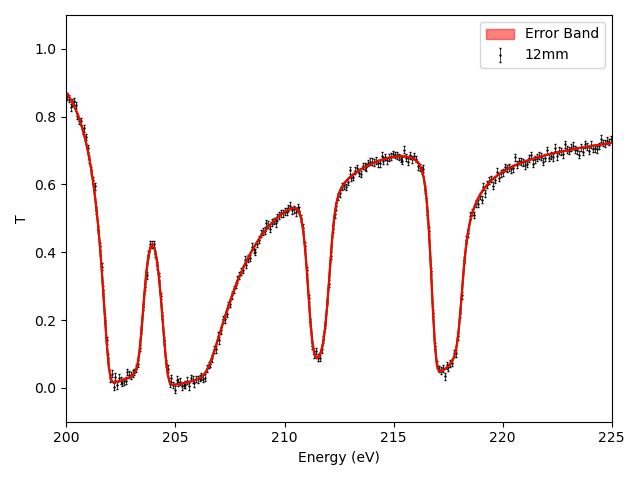

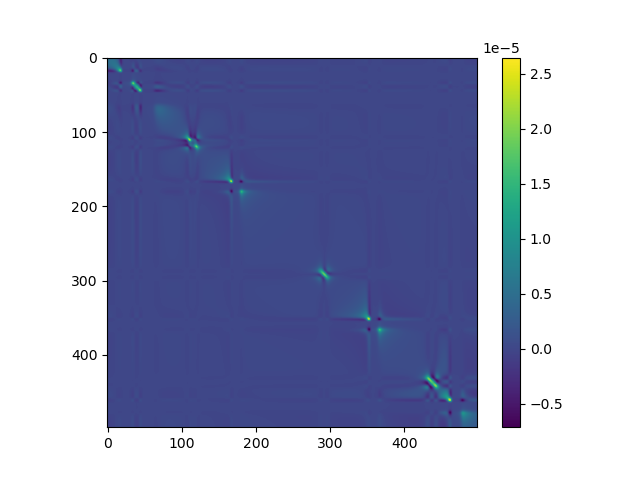

In [21]:

### Plot 
figure()

errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(synT.data.E, synT.data.true, 'g')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans_bayes, 'r')
# plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

xlim([200,225])
ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


figure()
imshow(sammyOUT2.ECSCM)
colorbar()

In [22]:
sammyOUT2.pw

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,200.036807,2.238935,0.173037,2.124769,2.123985,0.860373,0.01,0.867004,0.867049
1,200.114985,2.372494,0.174596,2.256138,2.253972,0.852689,0.01,0.859387,0.859512
2,200.193209,2.819486,0.179918,2.401979,2.398278,0.827468,0.01,0.851010,0.851222
3,200.271479,2.561943,0.176832,2.564199,2.558792,0.841907,0.01,0.841788,0.842094
4,200.349795,2.491783,0.176000,2.744878,2.737568,0.845884,0.01,0.831634,0.832043
...,...,...,...,...,...,...,...,...,...
535,249.454916,9.410270,0.280115,9.366811,9.320276,0.531481,0.01,0.533055,0.534723
536,249.563790,9.181088,0.275836,9.102453,9.058231,0.539726,0.01,0.542604,0.544218
537,249.672735,8.323797,0.260401,8.864540,8.822397,0.571718,0.01,0.551344,0.552907
538,249.781752,9.112837,0.274575,8.649284,8.609020,0.542206,0.01,0.559374,0.560888


In [23]:
samples = 100

cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

for i in range(samples):
    # synT.run(sammyOUT.pw)
    synT.data.exp = np.random.default_rng().normal(synT.data.true, std)
    synT.data.exp_unc = std
    sammyINP.experimental_data = synT.data
    sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
    residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
    cov_true += residual.T@residual
    cov_est += sammyOUT2.ECSCM
    # true.append(cov_true)
    # est.append(cov_est)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'


KeyboardInterrupt: 

Empirical Fnorm
0.10601340535370715
Estimated Fnorm
0.6576157397531259


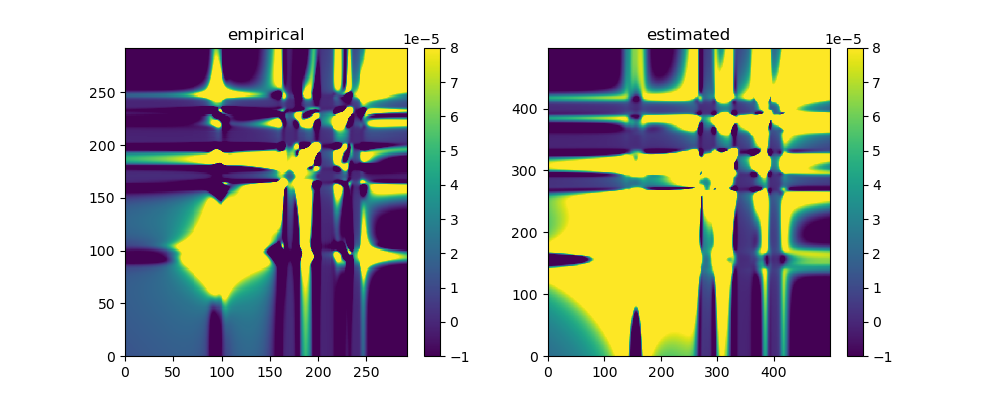

In [ ]:
iest = 0
fig, axes = subplots(1,2, figsize=(10,4))
# im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
axes[0].set_title("empirical")

axes[1].set_title("estimated")
# for ax in axes:
colorbar(im1)

colorbar(im2)

print("Empirical Fnorm")
print(np.linalg.norm(cov_true/(samples), ord='fro'))
print("Estimated Fnorm")
print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

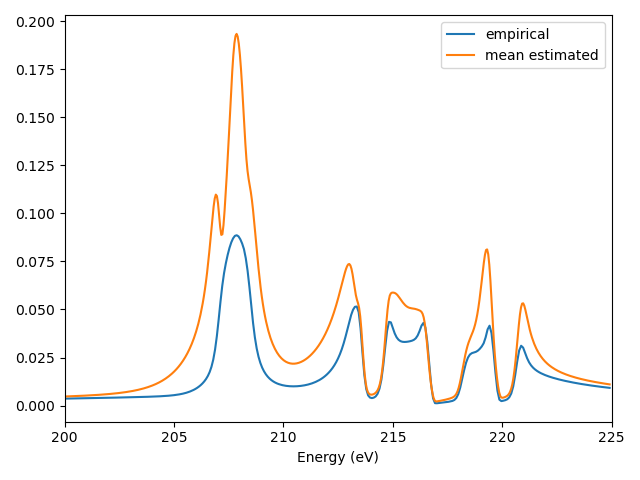

In [ ]:
### Plot 
figure()

# errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
#                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# plot(synT.data.E, synT.data.true, 'g')
plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()

In [ ]:
# result_dict = {}
# stds = [0.1, 0.01, 0.001, 0.0001]
stds = [0.00001, 0.05]

for istd in stds:
    samples = 1000
    cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
    cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
    for i in range(samples):
        # synT.run(sammyOUT.pw)
        synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
        synT.data.exp_unc = istd
        sammyINP.experimental_data = synT.data
        sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
        residual = np.atleast_2d(
            sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
        cov_true += residual.T@residual
        cov_est += sammyOUT2.ECSCM
        
    result_dict[istd] = [cov_true, cov_est]

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions

In [ ]:
stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
true= []
est = []

for istd in stds:
    res = result_dict[istd]
    cov_true = res[0]
    cov_est = res[1]
    print(istd)
    # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
    # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
    # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
    # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
    print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
    print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
    true.append(np.sum(np.diag(cov_true)**2/(samples)))
    est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

1.0
Empirical Fnorm:  205.909517650562
Estimated Fnorm:  13983.358879291103
0.1
Empirical Fnorm:  1.27312228848572
Estimated Fnorm:  20.57792407058932
0.05
Empirical Fnorm:  0.33956561892033876
Estimated Fnorm:  2.5216102153330824
0.01
Empirical Fnorm:  1.6064059375184373e-05
Estimated Fnorm:  2.7515973377491724e-05
0.001
Empirical Fnorm:  1.6325068672668157e-09
Estimated Fnorm:  2.7654315249556847e-09
0.0001
Empirical Fnorm:  1.6181263422363615e-13
Estimated Fnorm:  2.766300092741631e-13


Text(0.5, 0, 'Noise Level')

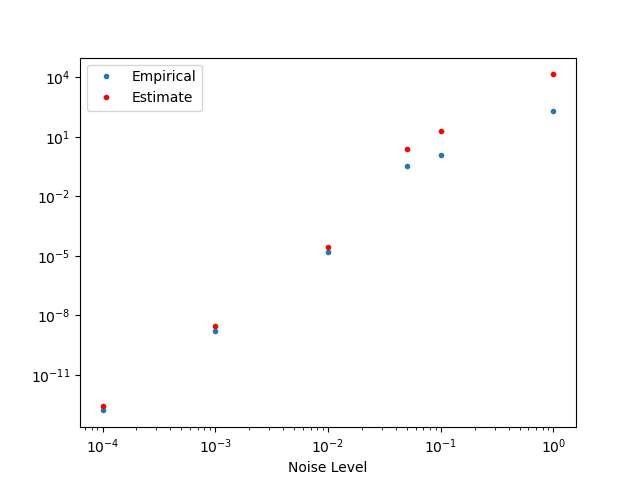

In [ ]:
figure()
plot(stds, true, '.', label='Empirical')
plot(stds, est, '.r', label='Estimate')
xscale("log")
yscale("log")
legend()
# ylabel("Noise Level")
xlabel("Noise Level")